In [2]:
%matplotlib inline

#text analysis
import os
from collections import Counter
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

#train
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV

from sklearn.pipeline import Pipeline


#text processing
from bs4 import BeautifulSoup
from nltk import word_tokenize, WordNetLemmatizer


# Text analysis

In [3]:
# Read file in the same folder.
df = pd.read_csv(r'emails.csv')

In [4]:
# Shape.
df.shape

(5728, 2)

In [5]:
# Detect missing values.
df.isna().sum()

text    0
spam    0
dtype: int64

In [6]:
# First 5 rows.
df.head()

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


In [7]:
# Last 5 rows
df.tail()

,text,spam
5723,Subject: re : research and development charges...,0
5724,"Subject: re : receipts from visit jim , than...",0
5725,Subject: re : enron case study update wow ! a...,0
5726,"Subject: re : interest david , please , call...",0
5727,Subject: news : aurora 5 . 2 update aurora ve...,0


In [10]:
# Detect duplicate values.
df[df.duplicated()].shape

(33, 2)

In [11]:
# Drop duplicate values.
df.drop_duplicates(inplace = True)

In [13]:
# Detect duplicate values.
df[df.duplicated()].shape

(0, 2)

In [14]:
# Apply a function along an axis of the DataFrame.
df['length']=df['text'].apply(len)
df.head()

,text,spam,length
0,Subject: naturally irresistible your corporate...,1,1484
1,Subject: the stock trading gunslinger fanny i...,1,598
2,Subject: unbelievable new homes made easy im ...,1,448
3,Subject: 4 color printing special request add...,1,500
4,"Subject: do not have money , get software cds ...",1,235


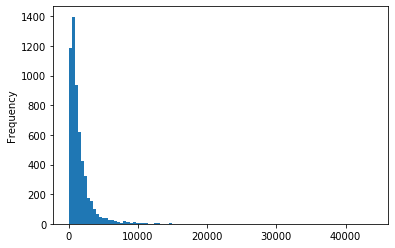

In [24]:
# The kind of plot to produce: histogram
df['length'].plot(bins=100,kind='hist')

In [25]:
df.length.describe()

count     5695.000000
mean      1558.067076
std       2047.078711
min         13.000000
25%        508.500000
50%        979.000000
75%       1893.000000
max      43952.000000
Name: length, dtype: float64

# NLTK

In [26]:
# Converting a word to its base form

# Init the Wordnet Lemmatizer
lemmatizer = WordNetLemmatizer()


def purify_text(message):
    soup = BeautifulSoup(message)
    text =  soup.get_text()
    text = text.replace("\n", " ").replace("/", "").replace("|", "").replace("http", "").replace(':', "").replace('\t', "").replace("Subject", "").replace('re', "").strip()
    
    # Split a sentence into words. Ex: "I love you." --> ["I", "love", "you", "."]. Similar to split().
    tokens = word_tokenize(text) 
    
    # Ex: playing or played --> Lemmatization --> play
    temp = [lemmatizer.lemmatize(word.lower()) for word in tokens] 
    return ' '.join(temp)

In [27]:
df['text'] = df['text'].apply(purify_text)

In [28]:
df.head()

,text,spam,length
0,naturally irsistible your corporate identity l...,1,1484
1,the stock trading gunslinger fanny is merrill ...,1,598
2,unbelievable new home made easy im wanting to ...,1,448
3,4 color printing special quest additional info...,1,500
4,"do not have money , get softwa cd from he ! so...",1,235


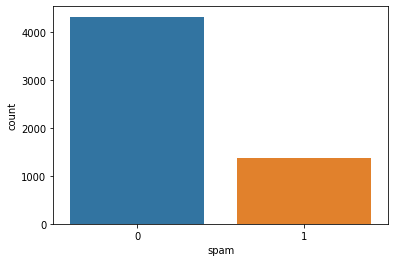

In [29]:
sns.countplot(df['spam'])

In [32]:
df[df['length']>3500]['spam'].value_counts()

0    396
1     87
Name: spam, dtype: int64

In [33]:
for index in df[df['length']>3500].index.tolist():
    df.drop(index=index, axis=1, inplace=True)

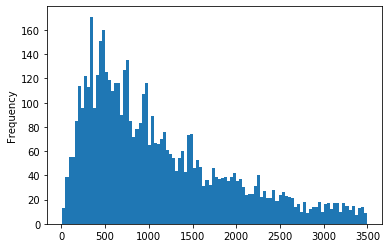

In [35]:
df['length'].plot(bins=100,kind='hist')

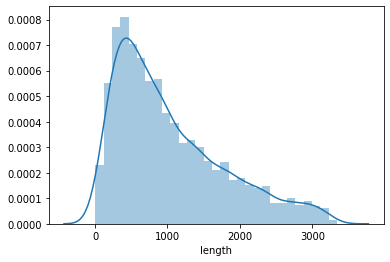

In [36]:
df['length'] = df['text'].apply(len)
sns.distplot(df['length'])

In [37]:
import string
from nltk.corpus import stopwords
def text_process(message):
    noPunc = [char for char in message if char not in string.punctuation]
    noPunc = ''.join(noPunc)
    
    return [word for word in noPunc.split() if word not in stopwords.words('english')]

In [42]:
text_process("Khang..,,., Tu ;';';[;[,]] 5C")

['Khang', 'Tu', '5C']

In [43]:
df['text'] = df['text'].apply(text_process)

In [44]:
df['text'].head()

0    [naturally, irsistible, corporate, identity, l...
1    [stock, trading, gunslinger, fanny, merrill, m...
2    [unbelievable, new, home, made, easy, im, want...
3    [4, color, printing, special, quest, additiona...
4    [money, get, softwa, cd, softwa, compatibility...
Name: text, dtype: object

In [45]:
df['text'] = df['text'].apply(lambda x: ' '.join(x))

In [46]:
df['text'].head()

0    naturally irsistible corporate identity lt all...
1    stock trading gunslinger fanny merrill muzo co...
2    unbelievable new home made easy im wanting sho...
3    4 color printing special quest additional info...
4    money get softwa cd softwa compatibility gat g...
Name: text, dtype: object

In [47]:
# Creating the Bag of Words model
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
bow_transformer = vectorizer.fit(df['text'])

In [48]:
print(len(bow_transformer.vocabulary_))

27730


In [52]:
message_bow = bow_transformer.transform(df['text'])

In [53]:
sparsity = (100.0 * message_bow.nnz/(message_bow.shape[0] * message_bow.shape[1]))
print('sparsity {}'.format(sparsity))

sparsity 0.26685968937947024


In [54]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer_bow = TfidfTransformer().fit(message_bow)

In [55]:
message_tfidf = tfidf_transformer_bow.transform(message_bow)

In [56]:
def buildClassifier(alpha):
    text_classifier = MultinomialNB(alpha=alpha)
    return text_classifier

In [57]:
pipeline = Pipeline([('vec', CountVectorizer()),
                   ('tfidf', TfidfTransformer()),
                   ('clf', MultinomialNB(alpha=0.01))])

In [58]:
parameters = {'clf__alpha': (0.00001, 0.0001, 0.001, 0.01, 0.1, 0.8, 0.9, 1)}
grid_search = GridSearchCV(estimator=pipeline, param_grid=parameters, scoring='accuracy', cv=10, verbose=1)

In [59]:
grid_search.fit(df['text'], df['spam'])
best_parameters = grid_search.best_params_
best_accuracy = grid_search.best_score_

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:   39.1s finished


In [60]:
best_parameters

{'clf__alpha': 0.01}

In [61]:
best_accuracy


0.9902173833109037

In [63]:
pipeline = Pipeline([('vec', CountVectorizer()),
                   ('tfidf', TfidfTransformer()),
                   ('clf', MultinomialNB(alpha=0.1))])

In [64]:
pipeline.fit(df['text'], df['spam'])

Pipeline(memory=None,
         steps=[('vec',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True))],
         verbose=False)

In [66]:
input_word = ['AutoReg(y, 0) will estimate an AR with no lags. Autoreg fits the model you specify and does not do automatic selection. There is a separate function for lag length selection.']
input_word = text_process(input_word)
input_word = [' '.join(input_word)]
pipeline.predict(input_word)

array([0])

In [104]:
# write-binary. Store data using Python pickle
import pickle

In [105]:
filename = 'emailSpamClf.pkl'
pickle.dump(pipeline, open(filename, 'wb'))